In [103]:
import qrcode
import pickle
import numpy as np

from enum import Enum, auto
from typing import List

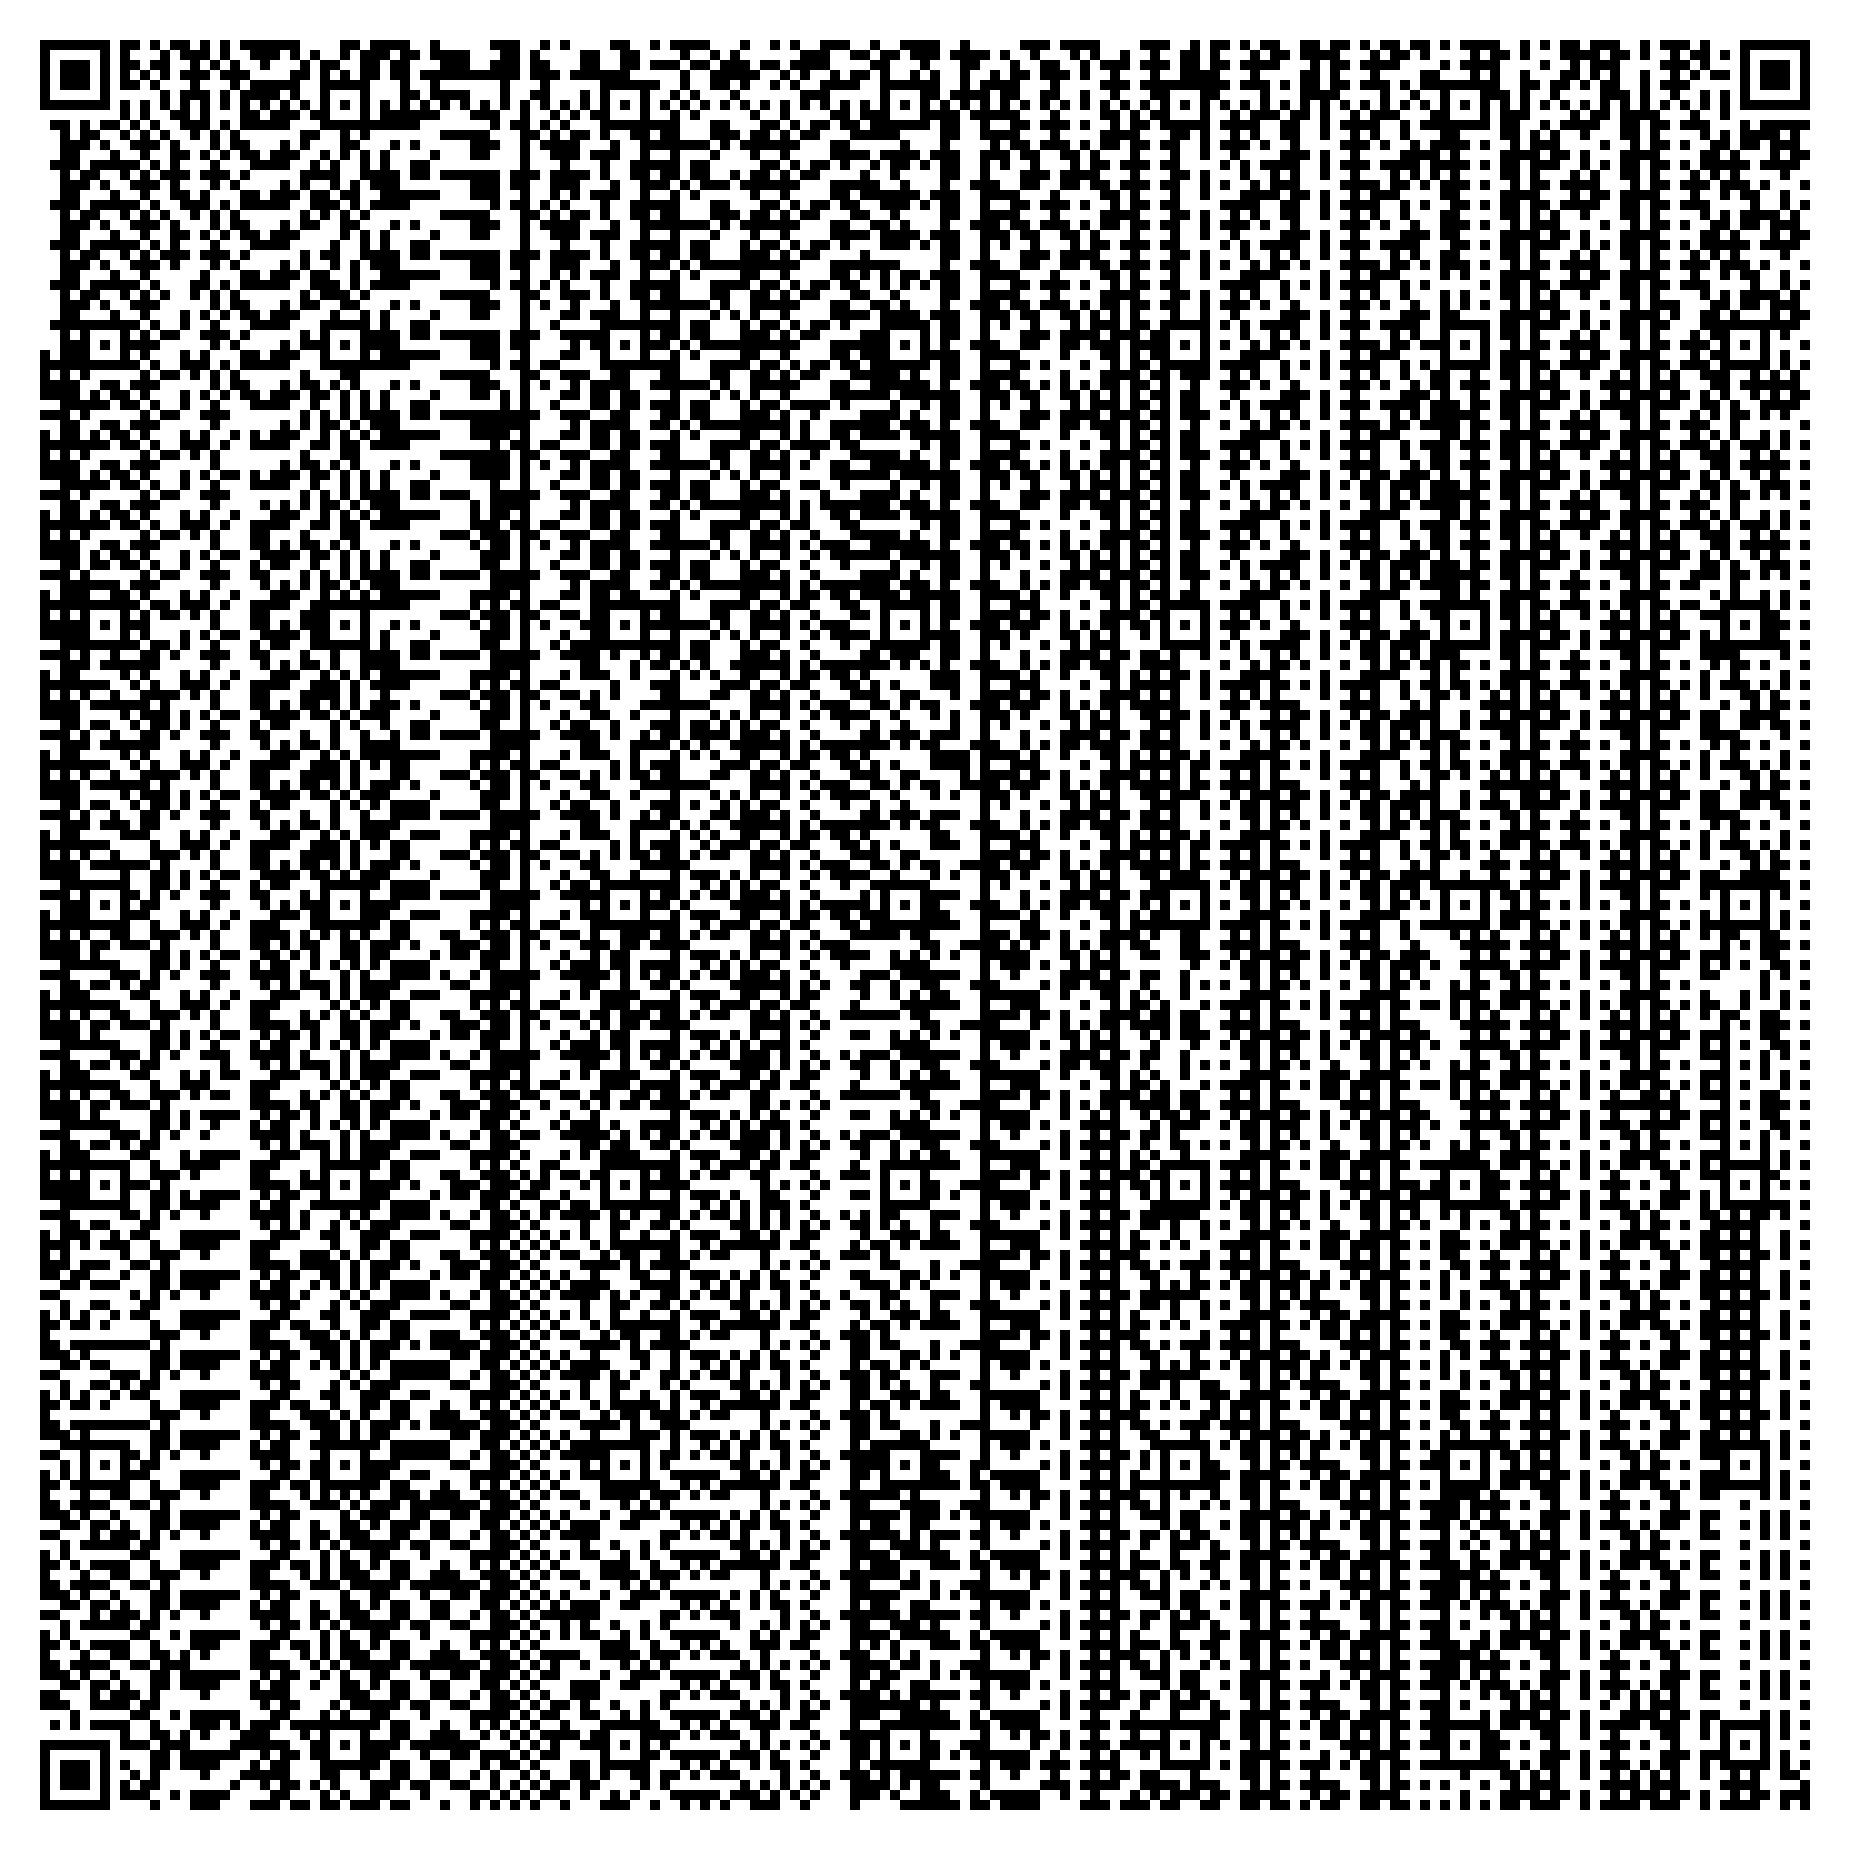

In [104]:
qr = qrcode.QRCode(error_correction=qrcode.ERROR_CORRECT_Q)
qr.add_data("HELLO WORLD")
qr.version = 40
qr.make_image()
# qr.add_data("9"*20)
# qr.best_fit()

In [105]:
# class ModeIndicator(Enum):
#     numeric_mode = 0b0001
#     alphanumeric_mode = 0b0010
#     byte_mode = 0b0100
#     kanji_mode = 0b1000
#     ECI_mode = 0b0111

# mode_indicator_mapping = {0b0001:0, 0b0010: 1, 0b0100:2, 0b1000:3}

class ModeIndicator(Enum):
    numeric_mode = 0
    alphanumeric_mode = 1
    byte_mode = 2
    kanji_mode = 3
    # ECI_mode = auto()

mode_indicator_mapping = {
    ModeIndicator.numeric_mode: "0001", 
    ModeIndicator.alphanumeric_mode: "0010", 
    ModeIndicator.byte_mode: "0100", 
    ModeIndicator.kanji_mode: "1000"
}

class ErrorCorrectionLevel(Enum):
    L = 1
    M = 2
    Q = 3
    H = 4

class SizeLevel(Enum):
    small = auto()
    medium = auto()
    large = auto()

assert mode_indicator_mapping[ModeIndicator.numeric_mode] == "0001"
assert mode_indicator_mapping[ModeIndicator.alphanumeric_mode] == "0010"
assert mode_indicator_mapping[ModeIndicator.byte_mode] == "0100"
assert mode_indicator_mapping[ModeIndicator.kanji_mode] == "1000"

In [106]:
# size_level
#   Small: 1 to 9
#   Medium: 10 to 26
#   Large: 27 to 40

def get_size_from_version(version: int) -> str:
    if not 0 < version < 41:
        raise ValueError(f"the specified version is not between 1 through 40 (inclusive): {version}")
    if 1 <= version <= 9:
        return SizeLevel.small
    if 10 <= version <= 26:
        return SizeLevel.medium
    if 27 <= version <= 40:
        return SizeLevel.large

assert get_size_from_version(5) == SizeLevel.small
assert get_size_from_version(9) == SizeLevel.small
assert get_size_from_version(26) == SizeLevel.medium
assert get_size_from_version(40) == SizeLevel.large

In [107]:
char_count_byte_length_for_version_and_mode = {
    SizeLevel.small : {
        ModeIndicator.numeric_mode : 10,
        ModeIndicator.alphanumeric_mode : 9,
        ModeIndicator.byte_mode : 8,
        ModeIndicator.kanji_mode : 8
    },
    SizeLevel.medium : {
        ModeIndicator.numeric_mode : 12,
        ModeIndicator.alphanumeric_mode : 11,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 10
    },
    SizeLevel.large : {
        ModeIndicator.numeric_mode : 14,
        ModeIndicator.alphanumeric_mode : 13,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 12
    }
}

def get_char_counter_pad(version: int, mode: ModeIndicator):
    return char_count_byte_length_for_version_and_mode[get_size_from_version(version)][mode]

assert get_char_counter_pad(1, ModeIndicator.alphanumeric_mode) == 9
assert get_char_counter_pad(20, ModeIndicator.byte_mode) == 16

def get_char_counter_binary(length: int, version: int, mode: ModeIndicator):
    pad = get_char_counter_pad(version, mode) # get the amount of padding needed
    return format(length, f">0{pad}b")  # pad the binary to the length specified

assert get_char_counter_binary(11, 1, ModeIndicator.alphanumeric_mode) == '000001011'
assert get_char_counter_binary(100, 30, ModeIndicator.alphanumeric_mode) == '0000001100100'

In [108]:
filepath = "../resources/version.pickle"

with open(filepath, "rb") as file:
    version_dict = pickle.load(file)

# version_dict[version-1][ErrorCorrectionLevel.XX][ModeIndicator.YY.value]
# XX: L, M, H, Q
# YY: numeric, alphanumeric, byte, kanji
assert version_dict[0][ErrorCorrectionLevel.M] == [34, 20, 14, 8]

In [109]:
def get_minimum_version(character_length: int, mode: ModeIndicator, error_correction_level: ErrorCorrectionLevel, minimum_version:int=1) -> int:
    """ get the minumum version (equivalent to the size of the qr code) for the specified mode and error correction level
    """
    for index, version in enumerate(version_dict):
        length_in_version = version[error_correction_level][mode.value]
        if length_in_version >= character_length:
            return max(index+1, minimum_version)

    raise Exception("too much data, can't fit inside QR-Code")

assert get_minimum_version(20, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.M, minimum_version=10) == 10
assert get_minimum_version(2000, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.L) == 27
assert get_minimum_version(2000, ModeIndicator.numeric_mode, ErrorCorrectionLevel.Q, minimum_version=26) == 28
assert get_minimum_version(2000, ModeIndicator.byte_mode, ErrorCorrectionLevel.L) == 33
assert get_minimum_version(7089, ModeIndicator.numeric_mode, ErrorCorrectionLevel.L) == 40 # biggest numeric possible

In [110]:
digits = "0123456789" # only digits
alphanumeric = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ $%*+-./:" # digits, cap_alphabet, space, $, %, *, +, -, ., /, :

def get_val_for_char(char):
    return alphanumeric.find(char)

assert get_val_for_char('A') == 10
assert get_val_for_char(':') == 44

def get_char_for_val(val):
    return alphanumeric[val]

assert get_char_for_val(10) == 'A'
assert get_char_for_val(44) == ':'

In [111]:
def get_mode(data):
    if set(data).issubset(digits): # or use re.match
        return ModeIndicator.numeric_mode
    elif set(data).issubset(alphanumeric):
        return ModeIndicator.alphanumeric_mode
    # elif # kanji
    #     print("use kanji mode")
        # mode_indicator = ModeIndicator.kanji_mode
    else:
        return ModeIndicator.byte_mode

assert get_mode("12434") == ModeIndicator.numeric_mode
assert get_mode("HELLO WORLD*+-123") == ModeIndicator.alphanumeric_mode
assert get_mode("324kjdsfSFJ!") == ModeIndicator.byte_mode

# not implemented:
#   - Extended Channel Interpretation (ECI) mode
#   - Structured Append mode
#   - FNC1 mode

In [112]:
# https://www.thonky.com/qr-code-tutorial/alphanumeric-mode-encoding
def encode_alphanumeric(data: str) -> str:
    encoded_data = ""
    pairs = [data[i:i+2] for i in range(0, len(data), 2)]
    
    for pair in pairs:
        if len(pair) == 1:
            val = get_val_for_char(pair)
            encoded_data += format(val, ">06b")
            break
        
        val1 = get_val_for_char(pair[0])
        val2 = get_val_for_char(pair[1])
        pair_val = (45*val1)+val2

        encoded_data += format(pair_val, ">011b")
    return encoded_data

assert encode_alphanumeric("HELLO WORLD") == '0110000101101111000110100010111001011011100010011010100001101'


# https://www.thonky.com/qr-code-tutorial/numeric-mode-encoding
def encode_numeric(data: str) -> str:
    encoded_data = ""
    pairs = [data[i:i+3] for i in range(0, len(data), 3)]

    for pair in pairs:
        if len(pair) == 1 or pair[0:2] == "00":
            encoded_data += format(int(pair), ">04b")
        elif len(pair) == 2 or pair[0] == "0":
            encoded_data += format(int(pair), ">07b")
        elif len(pair) == 3:
            encoded_data += format(int(pair), ">010b")
    return encoded_data

assert encode_numeric("8675309") == '110110001110000100101001'


# https://www.thonky.com/qr-code-tutorial/byte-mode-encoding
def encode_byte(data: str) -> str:
    data_bytes = data.encode("ISO 8859-1") # iso 8859 latin-1 (Western europe)
    # data_bytes = data.encode("UTF-8")

    encoded_data = "".join(format(byte, "0>8b") for byte in data_bytes)
    return encoded_data

assert encode_byte("Hello, world!") == '01001000011001010110110001101100011011110010110000100000011101110110111101110010011011000110010000100001'


# https://www.thonky.com/qr-code-tutorial/kanji-mode-encoding
def encode_kanji(data):
    raise NotImplementedError

def encode_data(data, mode):
    if mode == ModeIndicator.numeric_mode:
        return encode_numeric(data)
    elif mode == ModeIndicator.alphanumeric_mode:
        return encode_alphanumeric(data)
    elif mode == ModeIndicator.byte_mode:
        return encode_byte(data)
    elif mode == ModeIndicator.kanji_mode:
        return encode_kanji(data)

In [113]:
filepath = "../resources/error_correction_table.pickle"

with open(filepath, "rb") as file:
    error_correction_dict = pickle.load(file)

# error_correction_dict[(version, ErrorCorrectionLevel)][XX]
# XX: Total Number of Data Codewords, EC Codewords Per Block, Number of Blocks in Group 1, 
#     Number of Data Codewords in Each of Group 1's Blocks, Number of Blocks in Group 2, Number of Data Codewords in Each of Group 2's Blocks

assert error_correction_dict[(40, ErrorCorrectionLevel.H)] == (1276, 30, 20, 15, 61, 16)

In [114]:
def get_total_codewords(version: int, error_correction_level: ErrorCorrectionLevel) -> int:
    return error_correction_dict[(version, error_correction_level)][0]

assert get_total_codewords(1, ErrorCorrectionLevel.Q) == 13
assert get_total_codewords(40, ErrorCorrectionLevel.H) == 1276

def get_data_bits_required(version: int, error_correction_level: ErrorCorrectionLevel) -> int:
    return error_correction_dict[(version, error_correction_level)][0]*8

assert get_data_bits_required(20, ErrorCorrectionLevel.H) == 3080
assert get_data_bits_required(1, ErrorCorrectionLevel.Q) == 104

In [115]:
def get_blocks_per_group(version: int, error_correction_level: ErrorCorrectionLevel) -> List[int]:
    error_correction_info = error_correction_dict[(version, error_correction_level)]
    return [error_correction_info[2], error_correction_info[4]]

assert get_blocks_per_group(1, ErrorCorrectionLevel.Q) == [1, 0]
assert get_blocks_per_group(5, ErrorCorrectionLevel.Q) == [2, 2]
assert get_blocks_per_group(40, ErrorCorrectionLevel.L) == [19, 6]
assert get_blocks_per_group(33, ErrorCorrectionLevel.M) == [14, 21]

In [116]:
def get_codewords_per_block(version: int, error_correction_level: ErrorCorrectionLevel) -> List[int]:
    error_correction_info = error_correction_dict[(version, error_correction_level)]
    return [error_correction_info[3], error_correction_info[5]]

assert get_codewords_per_block(1, ErrorCorrectionLevel.Q) == [13, 0]
assert get_codewords_per_block(5, ErrorCorrectionLevel.Q) == [15, 16]
assert get_codewords_per_block(40, ErrorCorrectionLevel.L) == [118, 119]
assert get_codewords_per_block(33, ErrorCorrectionLevel.M) == [46, 47]

In [117]:
def add_terminator(total_bit_string: str, total_data_bits_required: int) -> int:
    """ returns the total bit string with the terminator appended
    """
    diffrence = total_data_bits_required - len(total_bit_string)
    terminator_length = min(4, diffrence)
    return total_bit_string + "0" * terminator_length

assert add_terminator('00100000010110110000101101111000110100010111001011011100010011010100001101', 104) == "001000000101101100001011011110001101000101110010110111000100110101000011010000"
# assert add_terminator('01000000000101100001', 104) == "010000000001011000010000"

In [118]:
def add_padding(total_bit_string: str) -> str:
    pad_length = 8-len(total_bit_string)%8
    return  total_bit_string + "0" * pad_length

assert add_padding("001000000101101100001011011110001101000101110010110111000100110101000011010000") == "00100000010110110000101101111000110100010111001011011100010011010100001101000000"

In [119]:
def fill_with_pad_bytes(total_bit_string: str, total_data_bits_required: int) -> str:
    """ fill the total_bit_string with the pad_bytes, alternating
    """
    pad_byte1, pad_byte2 = "11101100", "00010001"

    while len(total_bit_string) < total_data_bits_required:
        total_bit_string += pad_byte1
        pad_byte1, pad_byte2 = pad_byte2, pad_byte1

    return total_bit_string

assert len(fill_with_pad_bytes("00100000010110110000101101111000110100010111001011011100010011010100001101000000", 104)) == 104
assert fill_with_pad_bytes("00100000010110110000101101111000110100010111001011011100010011010100001101000000", 104) == "00100000010110110000101101111000110100010111001011011100010011010100001101000000111011000001000111101100"

In [120]:
def split_string_into_chunks(string, chunk_size=8):
    """ split a string into evenly sized chunks
    """
    return [string[index:(index+chunk_size)] for index in range(0, len(string), chunk_size)]

In [121]:
def split_in_groups(codewords: List[str], num_of_blocks_per_group: int, num_of_codewords_per_block: int) -> List[List[List[str]]]:
    """
    The codewords need to be sorted into 2 Groups, each containing x and y block respectivly
    In Group 1 each Block contains n codewords, in Group 2 each block contains m codewords

    The codewords need to be sorted into 2 Groups, each containing 'num_of_blocks_per_group[0]' and 'num_of_blocks_per_group[1]' blocks respectivly
    In Group 1 each Block contains 'num_of_codewords_per_block[0]' codewords, in Group 2 each block contains 'num_of_codewords_per_block[1]' codewords
    
    Group 1                 | Group 2
    Block 1 ... Block x     | Block 1 ... Block y
    n or m number of codewords per block
    """
    groups = []
    for group_index in range(2):
        group_offset = group_index*num_of_blocks_per_group[0]*num_of_codewords_per_block[0]
        group = []

        for block_index in range(num_of_blocks_per_group[group_index]):
            block_offset = block_index*num_of_codewords_per_block[group_index]
            
            block = [codewords[group_offset + block_offset + codeword_index_in_block] for codeword_index_in_block in range(num_of_codewords_per_block[group_index])]
            group.append(block)
        groups.append(group)

    return groups

In [122]:
data = "HELLO WORLD"
error_correction_level = ErrorCorrectionLevel.Q
mode = get_mode(data)
version = get_minimum_version(len(data), mode, error_correction_level)
# version = 5

mode_indicator = mode_indicator_mapping[mode]
character_count_indicator = get_char_counter_binary(len(data), version, mode)
encoded_data = encode_data(data, mode)
total_data_bits_required = get_total_codewords(version, error_correction_level)*8

total_bit_string = mode_indicator + character_count_indicator + encoded_data
total_bit_string = add_terminator(total_bit_string, total_data_bits_required)
total_bit_string = add_padding(total_bit_string)
# assert total_bit_string == "00100000010110110000101101111000110100010111001011011100010011010100001101000000"
total_bit_string = fill_with_pad_bytes(total_bit_string, total_data_bits_required)
assert total_bit_string == "00100000010110110000101101111000110100010111001011011100010011010100001101000000111011000001000111101100"

In [123]:
print(f"{data=}, {len(data)=}, {error_correction_level.name=}, {mode.name=}, {version=}")
print(f"{mode_indicator=}")
print(f"{character_count_indicator=}")
print(f"{encoded_data=}")
print(f"{total_data_bits_required=}")
print(f"{total_bit_string=}, {len(total_bit_string)=}")

data='HELLO WORLD', len(data)=11, error_correction_level.name='Q', mode.name='alphanumeric_mode', version=1
mode_indicator='0010'
character_count_indicator='000001011'
encoded_data='0110000101101111000110100010111001011011100010011010100001101'
total_data_bits_required=104
total_bit_string='00100000010110110000101101111000110100010111001011011100010011010100001101000000111011000001000111101100', len(total_bit_string)=104


In [124]:
# groups and blocks

num_of_blocks_per_group = get_blocks_per_group(version, error_correction_level)
num_of_codewords_per_block = get_codewords_per_block(version, error_correction_level)
total_codewords = get_total_codewords(version, error_correction_level)

# codewords is the total_bit_string as chunks of bytes
codewords = split_string_into_chunks(total_bit_string, 8)
assert all(len(codeword) == 8 for codeword in codewords)
# print(codewords)

groups = split_in_groups(codewords, num_of_blocks_per_group, num_of_codewords_per_block)

In [125]:
print(f"{num_of_blocks_per_group=}")
print(f"{num_of_codewords_per_block=}")
print(f"{total_codewords=}")
print(groups)

num_of_blocks_per_group=[1, 0]
num_of_codewords_per_block=[13, 0]
total_codewords=13
[[['00100000', '01011011', '00001011', '01111000', '11010001', '01110010', '11011100', '01001101', '01000011', '01000000', '11101100', '00010001', '11101100']], []]


In [126]:
# test with a Q-5 qr code
test_Q5_total_bit_string = "0100001101010101010001101000011001010111001001100101010111000010011101110011001000000110000100100000011001100111001001101111011011110110010000100000011101110110100001101111001000000111001001100101011000010110110001101100011110010010000001101011011011100110111101110111011100110010000001110111011010000110010101110010011001010010000001101000011010010111001100100000011101000110111101110111011001010110110000100000011010010111001100101110000011101100000100011110110000010001111011000001000111101100"
test_Q5_version = 5
test_Q5_error_correction_level = ErrorCorrectionLevel.Q
test_Q5_result = [[['01000011', '01010101', '01000110', '10000110', '01010111', '00100110', '01010101', '11000010', '01110111', '00110010', '00000110', '00010010', '00000110', '01100111', '00100110'], ['11110110', '11110110', '01000010', '00000111', '01110110', '10000110', '11110010', '00000111', '00100110', '01010110', '00010110', '11000110', '11000111', '10010010', '00000110']], [['10110110', '11100110', '11110111', '01110111', '00110010', '00000111', '01110110', '10000110', '01010111', '00100110', '01010010', '00000110', '10000110', '10010111', '00110010', '00000111'], ['01000110', '11110111', '01110110', '01010110', '11000010', '00000110', '10010111', '00110010', '11100000', '11101100', '00010001', '11101100', '00010001', '11101100', '00010001', '11101100']]]

test_Q5_num_of_blocks_per_group = get_blocks_per_group(test_Q5_version, test_Q5_error_correction_level)
test_Q5_num_of_codewords_per_block = get_codewords_per_block(test_Q5_version, test_Q5_error_correction_level)
test_Q5_total_codewords = get_total_codewords(test_Q5_version, test_Q5_error_correction_level)

test_Q5_codewords = split_string_into_chunks(test_Q5_total_bit_string, 8)
assert all(len(test_Q5_codeword) == 8 for test_Q5_codeword in test_Q5_codewords)

test_Q5_groups = split_in_groups(test_Q5_codewords, test_Q5_num_of_blocks_per_group, test_Q5_num_of_codewords_per_block)
assert test_Q5_groups == test_Q5_result